In [243]:
import os
import zipfile
import itertools
import numpy as np
import pandas as pd 
from numbers import Number
import sqlite3
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings
from collections import Counter
warnings.filterwarnings('ignore')

import pickle

# SQL Data
> - Unzipping file (im.db.zip), making a connection, conn and assigning a cursor
> - Opening file as a dataframe
> - Creating a single table with relevant data for us to use:

In [244]:
# Check if 'im.db' exists, unzip if it doesn't
if not os.path.exists('zippedData/im.db'):
    with zipfile.ZipFile('zippedData/im.db.zip', 'r') as zip_ref:
        zip_ref.extractall('zippedData')

# Connect to the SQLite database
conn = sqlite3.connect('zippedData/im.db')

In [245]:
cursor = conn.cursor()

In [246]:
pd.read_sql("""
  SELECT *
  FROM sqlite_master  
  """, conn)

,type,name,tbl_name,rootpage,sql
0,table,movie_basics,movie_basics,2,"CREATE TABLE ""movie_basics"" (\n""movie_id"" TEXT..."
1,table,directors,directors,3,"CREATE TABLE ""directors"" (\n""movie_id"" TEXT,\n..."
2,table,known_for,known_for,4,"CREATE TABLE ""known_for"" (\n""person_id"" TEXT,\..."
3,table,movie_akas,movie_akas,5,"CREATE TABLE ""movie_akas"" (\n""movie_id"" TEXT,\..."
4,table,movie_ratings,movie_ratings,6,"CREATE TABLE ""movie_ratings"" (\n""movie_id"" TEX..."
5,table,persons,persons,7,"CREATE TABLE ""persons"" (\n""person_id"" TEXT,\n ..."
6,table,principals,principals,8,"CREATE TABLE ""principals"" (\n""movie_id"" TEXT,\..."
7,table,writers,writers,9,"CREATE TABLE ""writers"" (\n""movie_id"" TEXT,\n ..."


In [321]:
pd.read_sql("""
  SELECT *
  FROM  movie_basics
  """, conn)

,movie_id,primary_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,2017,80.0,"Comedy,Drama,Fantasy"
...,...,...,...,...,...
146139,tt9916538,Kuambil Lagi Hatiku,2019,123.0,Drama
146140,tt9916622,Rodolpho Teóphilo - O Legado de um Pioneiro,2015,NaN,Documentary
146141,tt9916706,Dankyavar Danka,2013,NaN,Comedy
146142,tt9916730,6 Gunn,2017,116.0,None


# SQL Data Cleaning and Joining
> > - Movie_ID, Genres, Avg_Rating, Num_Votes, Region, Category, Artist_Name, Screen_Time, and Movie_Title
> > - Where region is United States with Number of votes greater than 1000 and Average rating is 6 and above
> > - Removed all duplicates from our joining point primary key Movie_ID and foreign Key Person_ID

In [343]:
#Select relevant data for computation and set certain cleaning papmeters such as region = US, Death_year Is null and avgrating >=6
Merged_SQL = pd.read_sql("""
SELECT mb.movie_id AS Movie_ID, mb.genres AS Genres, mr.averagerating AS Avg_Rating, mr.numvotes AS Num_Votes, mk.region AS Region, 
pr.category AS Category, p.primary_name AS Artist_Name, mb.runtime_minutes AS Screen_Time, mb.primary_title AS Movie_Title,
p.death_year As Death_Year
FROM movie_basics mb
JOIN movie_akas mk ON mk.movie_id = mb.movie_id
JOIN movie_ratings mr ON mr.movie_id = mb.movie_id
JOIN principals pr ON pr.movie_id = mb.movie_id
JOIN persons p ON p.person_id = pr.person_id
WHERE mk.region = 'US'
AND death_year IS NULL
;""", conn)
#More cleaning using pandas, dropped duplicates, set the defining catagories and dropped missing/empty values from Genre
Merged_SQL = Merged_SQL.drop_duplicates(subset=['Movie_ID'])
Merged_SQL = Merged_SQL.dropna(subset=['Genres'])
categories_of_interest = ['actor', 'actress', 'writer', 'director', 'producer']
Merged_SQL = Merged_SQL[Merged_SQL['Category'].isin(categories_of_interest)]
#Created a weighted average for rating
Merged_SQL['Weighted_Avg'] = (Merged_SQL['Avg_Rating'] * Merged_SQL['Num_Votes']) / Merged_SQL['Num_Votes'].sum()
Merged_SQL

,Movie_ID,Genres,Avg_Rating,Num_Votes,Region,Category,Artist_Name,Screen_Time,Movie_Title,Death_Year,Weighted_Avg
0,tt0369610,"Action,Adventure,Sci-Fi",7.0,539338,US,producer,Patrick Crowley,124.0,Jurassic World,None,1.805990e-02
45,tt0401729,"Action,Adventure,Sci-Fi",6.6,241792,US,actor,Willem Dafoe,132.0,John Carter,None,7.633825e-03
81,tt1014759,"Adventure,Family,Fantasy",6.5,358813,US,actor,Johnny Depp,108.0,Alice in Wonderland,None,1.115675e-02
118,tt1194173,"Action,Adventure,Thriller",6.7,268678,US,actor,Scott Glenn,135.0,The Bourne Legacy,None,8.611191e-03
136,tt1210047,"Comedy,Crime,Mystery",5.9,56,US,director,Kirk Bowman,107.0,Snatched!,None,1.580507e-06
...,...,...,...,...,...,...,...,...,...,...,...
260379,tt7315526,"Horror,Thriller",4.9,1466,US,actor,Chris Caputo,76.0,Devil's Tree: Rooted Evil,None,3.436263e-05
260388,tt7315648,Documentary,6.0,27,US,producer,Christian Everhard,100.0,OJ: Guilty in Vegas,None,7.749458e-07
260392,tt9080630,"Comedy,Drama,Romance",2.1,112,US,producer,Todd Burrows,122.0,Girl/Girl Scene,None,1.125107e-06
260408,tt9310460,"Adventure,Animation,Comedy",5.9,43,US,writer,Gabriele Walther,NaN,Coconut the Little Dragon 2 Into the Jungle,None,1.213603e-06


> - Seperating and analysing the Genre column
> - Assign the Thriller and Horror values to Thriller_Horror
> - Find the 5 most appearing Genre

In [358]:
# Split the values in each row and create a list
values = [val.strip() for sublist in Merged_SQL['Genres'].str.split(',') for val in sublist]

value_counts = Counter(values)

# Find the top 5 values that appear in the most rows
top_5_Genres = value_counts.most_common(6)

print("5 Genres that have the most ratings:")
for value, count in top_5_Genres:
    print(value, ":", count)

5 Genres that have the most ratings:
Drama : 8530
Comedy : 5326
Horror : 3635
Thriller : 3326
Documentary : 3029
Action : 2646


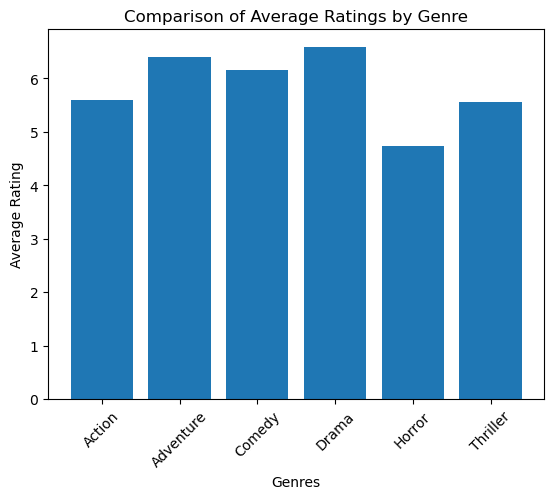

In [357]:
# top_5_genres = ['Drama', 'Comedy', 'Horror', 'Thriller', 'Adventure']
# top_5_ratings = [8530, 5326, 3635, 3326, 3029, 406]

# Filter the data to include only the rows with the top 5 genres
filtered_data = Merged_SQL[Merged_SQL['Genres'].isin(top_5_genres)]

# Group the filtered data by genre and calculate the mean of the average ratings
genre_avg_ratings = filtered_data.groupby('Genres')['Avg_Rating'].mean()

# Plot a bar graph to compare the average ratings of each genre
plt.bar(genre_avg_ratings.index, genre_avg_ratings.values)
plt.xlabel('Genres')
plt.ylabel('Average Rating')
plt.title('Comparison of Average Ratings by Genre')
plt.xticks(rotation=45)
plt.show()

# CSV Files
> - Uploaded Zipped csv files and printed columns
> - Dropped Not needed columns from each file
> - Decide to also drop data with more that 50% of value missing

In [356]:
# Reading the movie info data
movie_info_df = pd.read_csv('zippedData/rt.movie_info.tsv.gz', sep='\t', compression='gzip')

# Dropping unnecessary columns from movie info data
movie_info_drop = ['box_office', 'currency', 'dvd_date', 'studio']
movie_info_df = movie_info_df.drop(columns=movie_info_drop)

# Printing the columns of movie info data
print("movie_info_df columns:")
print(list(movie_info_df.columns))
print()

# Reading the movie gross data
movie_gross_df = pd.read_csv('zippedData/bom.movie_gross.csv.gz')

# Printing the columns of movie gross data
print("movie_gross_df columns:")
print(list(movie_gross_df.columns))
print()

# Reading the movie budget data
movie_budget_df = pd.read_csv('zippedData/tn.movie_budgets.csv.gz')

# Printing the columns of movie budget data
print("movie_budget_df columns:")
print(list(movie_budget_df.columns))
print()

# Reading the movie reviews data
movie_reviews_df = pd.read_csv('zippedData/rt.reviews.tsv.gz', sep='\t', compression='gzip', encoding='latin-1')

# Dropping unnecessary column from movie reviews data
movie_review_drop = ['rating']
movie_reviews_df = movie_reviews_df.drop(columns=movie_review_drop)

# Printing the columns of movie reviews data
print("movie_reviews_df columns:")
print(list(movie_reviews_df.columns))
print()

# Reading the tmdb movie data
tmbd_movie_df = pd.read_csv('zippedData/tmdb.movies.csv.gz')

# Printing the columns of tmdb movie data
print("tmbd_movie_df columns:")
print(list(tmbd_movie_df.columns))
print()

movie_info_df columns:
['id', 'synopsis', 'rating', 'genre', 'director', 'writer', 'theater_date', 'runtime']

movie_gross_df columns:
['title', 'studio', 'domestic_gross', 'foreign_gross', 'year']

movie_budget_df columns:
['id', 'release_date', 'movie', 'production_budget', 'domestic_gross', 'worldwide_gross']

movie_reviews_df columns:
['id', 'review', 'fresh', 'critic', 'top_critic', 'publisher', 'date']

tmbd_movie_df columns:
['Unnamed: 0', 'genre_ids', 'id', 'original_language', 'original_title', 'popularity', 'release_date', 'title', 'vote_average', 'vote_count']

